# Sloan Digital Sky Survey Exploration

See the scikit-learn tutorial for all sorts of processing tips and codes, e.g. code to automaticlly interegate SDSS, data analysis, plotting, etc...
Astronomy(SDSS)-specific tutorial: http://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/tutorial/astronomy/index.html#


## Ideas To Develop

PIPELINE:

Identify all objects with spectra in SDSS DR14 - stars, galaxies, QSOs, etc...
Use SQL queries direct from pyhton -> sdss. First of all use a web browser scraper; now utilise bulk download from database

10-D color space (u-g, u-r, u-i, u-z, g-r, g-i, g-z, r-i, r-z, i-z) and redshift (s.z)[see Redshifting of a Spectrum figure above] as a data cube
Work step-wise through the data cube and form a list of objects for each step
Auto-download fits files for each object: spectra ± photometry ± images
Composite of spectra within each step, including automated normalisation techniques (check literature for best way to do this ?flat continuum, or ?line analysis), and correction to rest frame based on s.z

Automated analysis of composite spectrum - continuum and lines; use table of line spectra rest wavelenghts

Automated FHWM calculations, and velocity dispersion calculations

? automated image analysis

? tie in with radio data, IR data (2MASS, Spitzer), UV data, X-ray data (Chandra, X-Newton), gamma data, and any other publicly accessible databases

Infer some new science!

Write article.



## SQL

THE big data way is to probably use this: http://www.sciserver.org/docs/sciscript-python/index.html
There's some example notebooks here - https://github.com/sciserver/SciScript-Python



But... on a smaller scale to start with, the following code allows direct access to the SQL browser form of SDSS, and downloads the SQL csv file directly into a pandas dataframe. 

Alternatively could use CasJobs CLI at http://skyserver.sdss.org/CasJobs/casjobscl.aspx

In [52]:
# Starting here - http://nbviewer.jupyter.org/github/drphilmarshall/match.halos/blob/master/match.ipynb
# Querying skyserver, using code from Eduardo Martin's blog post at
# http://balbuceosastropy.blogspot.com/2013/10/an-easy-way-to-make-sql-queries-from.html

# Updates I have included are MechanicalSoup is used to replace mechanize 
# https://mechanicalsoup.readthedocs.io/en/stable/
# io replaces StringIO, and dr14 of SDSS is accessed

%matplotlib inline
import os
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt

def SDSS_select(sql):
    from io import StringIO # To read a string like a file (changed from StringIO import StringIO for Python 3.6)
    import mechanicalsoup
    browser = mechanicalsoup.StatefulBrowser()
    url = "http://skyserver.sdss.org/dr14/en/tools/search/sql.aspx"
    browser.open(url)
    browser.select_form()
        
    browser["cmd"] = "sql"
    browser["format"] = "csv"
    response = browser.submit_selected()

    file_like = StringIO(response.get_data())
    return pd.read_csv(file_like,  skiprows=1)

In [53]:
browser.get_url()

'http://skyserver.sdss.org/dr14/en/tools/search/x_results.aspx?searchtool=SQL&TaskName=Skyserver.Search.SQL&syntax=NoSyntax&ReturnHtml=true&clear=Clear+Query&format=csv&TableName=&reset=Reset+&cmd=sql'

In [54]:
# start SQL code here, in red
objects = \
"SELECT top 10 \
objid, ra, dec, z, \
dered_u AS mag_u, \
dered_g AS mag_g, \
dered_r AS mag_r, \
dered_i AS mag_i, \
dered_z AS mag_z \
FROM SpecPhoto \
WHERE \
(class = 'Galaxy')"
# end SQL
print(objects)

SELECT top 10 objid, ra, dec, z, dered_u AS mag_u, dered_g AS mag_g, dered_r AS mag_r, dered_i AS mag_i, dered_z AS mag_z FROM SpecPhoto WHERE (class = 'Galaxy')


In [55]:
df1 = SDSS_select(objects)
df1.head()

AttributeError: 'Response' object has no attribute 'get_url'

In [ ]:
# df1.to_csv('sdss_data.csv') # do path/file with os

The following python script (sqlcl.py) from the SDSS website aims to interogate the SDSS database; it is now obsolete but may have some useful code in it!

In [ ]:
astro_url='http://skyserver.sdss3.org/public/en/tools/search/x_sql.asp' # dead link
public_url='http://skyserver.sdss3.org/public/en/tools/search/x_sql.asp' #dead link

default_url=public_url
default_fmt='csv'

def usage(status, msg=''):
    "Error message and usage"
    print(__doc__)
    if msg:
        print('-- ERROR: %s' % msg)
    sys.exit(status)

def filtercomment(sql):
    "Get rid of comments starting with --"
    import os
    fsql = ''
    for line in sql.split('\n'):
        fsql += line.split('--')[0] + ' ' + os.linesep;
    return fsql

def query(sql,url=default_url,fmt=default_fmt):
    "Run query and return file object"
    import urllib
    fsql = filtercomment(sql)
    params = urllib.urlencode({'cmd': fsql, 'format': fmt})
    return urllib.urlopen(url+'?%s' % params)    

def write_header(ofp,pre,url,qry):
    import  time
    ofp.write('%s SOURCE: %s\n' % (pre,url))
    ofp.write('%s TIME: %s\n' % (pre,time.asctime()))    
    ofp.write('%s QUERY:\n' % pre)
    for l in qry.split('\n'):
        ofp.write('%s   %s\n' % (pre,l))
    
def main(argv):
    "Parse command line and do it..."
    import os, getopt, string
    
    queries = []
    url = os.getenv("SQLCLURL",default_url)
    fmt = default_fmt
    writefirst = 1
    verbose = 0
    
    # Parse command line
    try:
        optlist, args = getopt.getopt(argv[1:],'s:f:q:vlh?')
    except getopt.error, e:
        usage(1,e)
        
    for o,a in optlist:
        if   o=='-s': url = a
        elif o=='-f': fmt = a
        elif o=='-q': queries.append(a)
        elif o=='-l': writefirst = 0
        elif o=='-v': verbose += 1
        else: usage(0)
        
    if fmt not in formats:
        usage(1,'Wrong format!')

    # Enqueue queries in files
    for fname in args:
        try:
            queries.append(open(fname).read())
        except IOError, e:
            usage(1,e)

    # Run all queries sequentially
    for qry in queries:
        ofp = sys.stdout
        if verbose:
            write_header(ofp,'#',url,qry)
        file = query(qry,url,fmt)
        # Output line by line (in case it's big)
        line = file.readline()
        if line.startswith("ERROR"): # SQL Statement Error -> stderr
            ofp = sys.stderr
        if writefirst:
            ofp.write(string.rstrip(line)+os.linesep)
        line = file.readline()
        while line:
            ofp.write(string.rstrip(line)+os.linesep)
            line = file.readline()


if __name__=='__main__':
    import sys
    main(sys.argv)


# scikit-learn

Astronomy(SDSS)-specific tutorial: http://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/tutorial/astronomy/index.html#; https://github.com/jakevdp/sklearn_tutorial and https://github.com/jakevdp/scikit-learn/

The github resources by Jake VdP include notebooks with details of scikit-learn processes. This https://github.com/jakevdp/PythonDataScienceHandbook probably has a lot of good ML stuff too

Once more advanced, check out these examples that one could modify: http://scikit-learn.org/stable/auto_examples/index.html

In [ ]:
%matplotlib inline
import os
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt

import sklearn
# astropy units, io, modeling, etc...
# scipy modeling, optimize, etc...

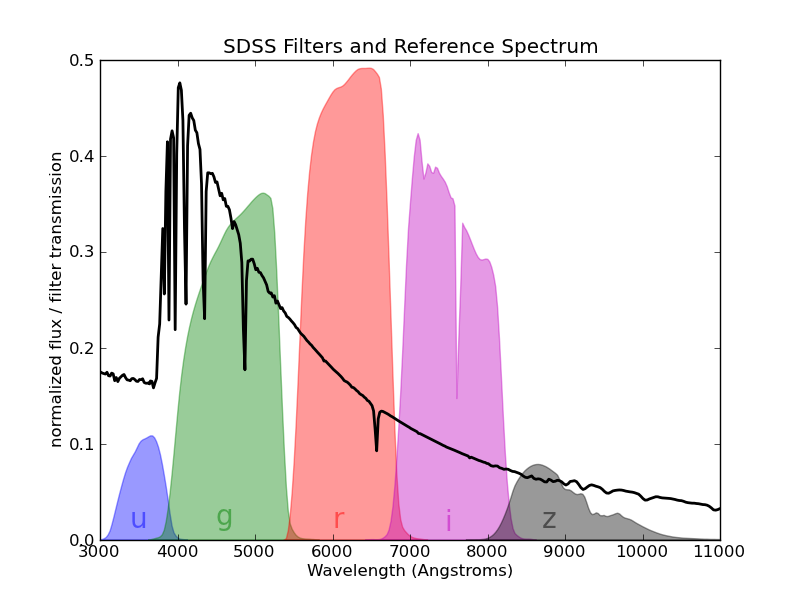

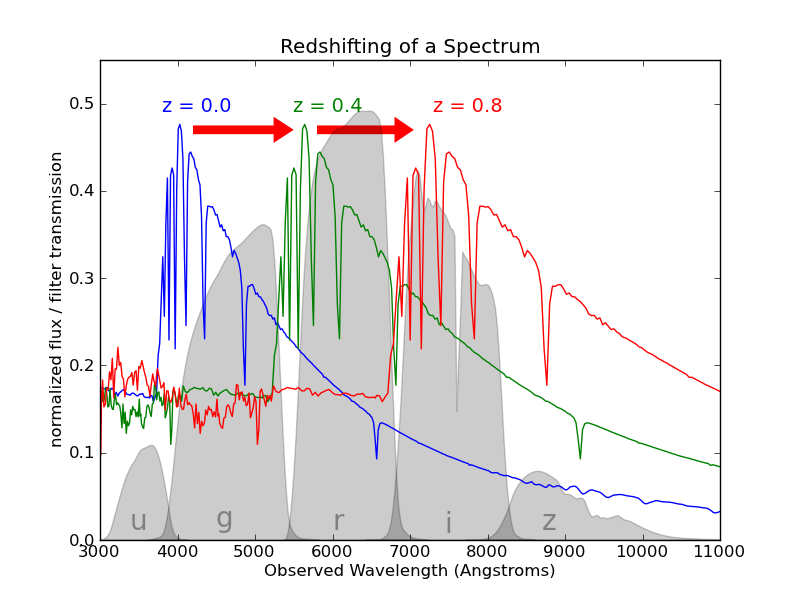

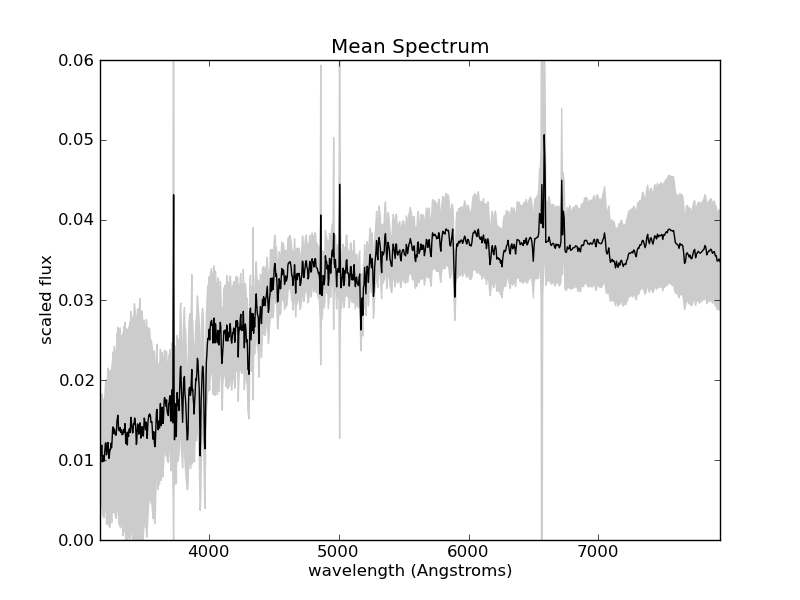

"The interesting part of the data is in the gray shaded regions: how do spectra vary from the mean, and how can this variation tell us about their physical properties? One option to visualize this would be to scatter-plot random pairs of observations from each spectrum." (Jake VdP).

How to plot it example...


In [ ]:
from sklearn import preprocessing
X = preprocessing.normalize(X)
mu = X.mean(0)
std = X.std(0)
pl.plot(wavelengths, mu, color='black')
pl.fill_between(wavelengths, mu - std, mu + std, color='#CCCCCC')
pl.xlim(wavelengths[0], wavelengths[-1])
pl.ylim(0, 0.06)
pl.xlabel('wavelength (Angstroms)')
pl.ylabel('scaled flux')
pl.title('Mean Spectrum')

## References & Bibliography

C.W. Yip et al. Spectral Classification of Quasars in the Sloan Digital Sky Survey: Eigenspectra, Redshift, and Luminosity Effects. Astronomical Journal 128:6, 2004.